<a href="https://colab.research.google.com/github/yasmine-houri/Word_embeddings/blob/main/Code_word_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word embeddings

This tutorial contains an introduction to word embeddings. You will train your own word embeddings using a simple Keras model for a sentiment classification task, and then visualize them in the [Embedding Projector](http://projector.tensorflow.org) (shown in the image below). 

<img src="https://github.com/tensorflow/text/blob/master/docs/guide/images/embedding.jpg?raw=1" alt="Screenshot of the embedding projector" width="400"/>

## Representing text as numbers

Machine learning models take vectors (arrays of numbers) as input. When working with text, the first thing you must do is come up with a strategy to convert strings to numbers (or to "vectorize" the text) before feeding it to the model. In this section, you will look at three strategies for doing so.

### One-hot encodings

As a first idea, you might "one-hot" encode each word in your vocabulary. Consider the sentence "The cat sat on the mat". The vocabulary (or unique words) in this sentence is (cat, mat, on, sat, the). To represent each word, you will create a zero vector with length equal to the vocabulary, then place a one in the index that corresponds to the word. This approach is shown in the following diagram.

<img src="https://github.com/tensorflow/text/blob/master/docs/guide/images/one-hot.png?raw=1" alt="Diagram of one-hot encodings" width="400" />

To create a vector that contains the encoding of the sentence, you could then concatenate the one-hot vectors for each word.

Key point: This approach is inefficient. A one-hot encoded vector is sparse (meaning, most indices are zero). Imagine you have 10,000 words in the vocabulary. To one-hot encode each word, you would create a vector where 99.99% of the elements are zero.

### Encode each word with a unique number

A second approach you might try is to encode each word using a unique number. Continuing the example above, you could assign 1 to "cat", 2 to "mat", and so on. You could then encode the sentence "The cat sat on the mat" as a dense vector like [5, 1, 4, 3, 5, 2]. This approach is efficient. Instead of a sparse vector, you now have a dense one (where all elements are full).

There are two downsides to this approach, however:

* The integer-encoding is arbitrary (it does not capture any relationship between words).

* An integer-encoding can be challenging for a model to interpret. A linear classifier, for example, learns a single weight for each feature. Because there is no relationship between the similarity of any two words and the similarity of their encodings, this feature-weight combination is not meaningful.

### Word embeddings

Word embeddings give us a way to use an efficient, dense representation in which similar words have a similar encoding. Importantly, you do not have to specify this encoding by hand. An embedding is a dense vector of floating point values (the length of the vector is a parameter you specify). Instead of specifying the values for the embedding manually, they are trainable parameters (weights learned by the model during training, in the same way a model learns weights for a dense layer). It is common to see word embeddings that are 8-dimensional (for small datasets), up to 1024-dimensions when working with large datasets. A higher dimensional embedding can capture fine-grained relationships between words, but takes more data to learn.

<img src="https://github.com/tensorflow/text/blob/master/docs/guide/images/embedding2.png?raw=1" alt="Diagram of an embedding" width="400"/>

Above is a diagram for a word embedding. Each word is represented as a 4-dimensional vector of floating point values. Another way to think of an embedding is as "lookup table". After these weights have been learned, you can encode each word by looking up the dense vector it corresponds to in the table.

## Setup

In [ ]:
import io
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import TextVectorization

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from datascience import *
import numpy as np
from scipy.spatial.distance import cosine
import gensim
import nltk
from string import punctuation
import pandas as pd

### Load the Dataset

In [ ]:
url = "https://raw.githubusercontent.com/yasmine-houri/Word_embeddings/main/"

metadata_tb = pd.read_csv(url+'Data/2_txtlab_Novel150.csv').drop('Unnamed: 0', axis=1)

fiction_path = url+'Data/'

novel_list = []

import requests
# Iterate through filenames in metadata table
for filename in metadata_tb['filename']:
    
    # Read in novel text as single string, make lowercase
    url = fiction_path + filename
    novel = requests.get(url)
    novel.encoding = 'utf-8-sig'
    
    # Add novel text as single string to master list
    novel_list.append(novel.text)


## Using the Embedding layer

Keras makes it easy to use word embeddings. Take a look at the [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer.

The Embedding layer can be understood as a lookup table that maps from integer indices (which stand for specific words) to dense vectors (their embeddings). The dimensionality (or width) of the embedding is a parameter you can experiment with to see what works well for your problem, much in the same way you would experiment with the number of neurons in a Dense layer.


In [ ]:
# Embed a 1,000 word vocabulary into 5 dimensions.
embedding_layer = tf.keras.layers.Embedding(1000, 5)

When you create an Embedding layer, the weights for the embedding are randomly initialized (just like any other layer). During training, they are gradually adjusted via backpropagation. Once trained, the learned word embeddings will roughly encode similarities between words (as they were learned for the specific problem your model is trained on).

If you pass an integer to an embedding layer, the result replaces each integer with the vector from the embedding table:

In [ ]:
result = embedding_layer(tf.constant([1, 2, 3]))
result.numpy()

array([[-0.02403584,  0.03738428, -0.01997154,  0.0469363 ,  0.04433168],
       [ 0.02075836,  0.04510358,  0.03625968,  0.04219678,  0.01917784],
       [ 0.01965772, -0.02144252,  0.0124194 , -0.03550881,  0.04285116]], dtype=float32)

For text or sequence problems, the Embedding layer takes a 2D tensor of integers, of shape `(samples, sequence_length)`, where each entry is a sequence of integers. It can embed sequences of variable lengths. You could feed into the embedding layer above batches with shapes `(32, 10)` (batch of 32 sequences of length 10) or `(64, 15)` (batch of 64 sequences of length 15).

The returned tensor has one more axis than the input, the embedding vectors are aligned along the new last axis. Pass it a `(2, 3)` input batch and the output is `(2, 3, N)`


In [ ]:
result = embedding_layer(tf.constant([[0, 1, 2], [3, 4, 5]]))
result.shape

TensorShape([2, 3, 5])

When given a batch of sequences as input, an embedding layer returns a 3D floating point tensor, of shape `(samples, sequence_length, embedding_dimensionality)`. To convert from this sequence of variable length to a fixed representation there are a variety of standard approaches. You could use an RNN, Attention, or pooling layer before passing it to a Dense layer. This tutorial uses pooling because it's the simplest. The [Text Classification with an RNN](https://www.tensorflow.org/text/tutorials/text_classification_rnn) tutorial is a good next step.

## Text preprocessing

Next, define the dataset preprocessing steps required for your sentiment classification model. Initialize a TextVectorization layer with the desired parameters to vectorize movie reviews. You can learn more about using this layer in the [Text Classification](https://www.tensorflow.org/tutorials/keras/text_classification) tutorial.

In [ ]:
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt')

def fast_tokenize(text):
    
    # Iterate through text removing punctuation characters
    no_punct = "".join([char for char in text if char not in punctuation])
    
    # Split text over whitespace into list of words
    tokens = no_punct.split()
    
    return tokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import random
randomlist = []
for i in range(0,50):
  n = random.randint(0,len(novel_list))
  randomlist.append(n)
randomlist= tuple(randomlist)

short_list = [novel_list[i] for i in randomlist]  

In [ ]:
sentences = [sentence for novel in short_list for sentence in sent_tokenize(novel)]

In [ ]:
words_by_sentence = [fast_tokenize(sentence.lower()) for sentence in sentences]

In [ ]:
words_by_sentence = [sentence for sentence in words_by_sentence if sentence != []]

## Train the model

You will use [TensorBoard](https://www.tensorflow.org/tensorboard) to visualize metrics including loss and accuracy. Create a `tf.keras.callbacks.TensorBoard`.

In [ ]:
model = gensim.models.Word2Vec(words_by_sentence, size=100, window=5, \
                               min_count=5, sg=0, alpha=0.025, iter=5, batch_words=10000)

## Embeddings

In [ ]:
print(model.similarity('femme','médecin'))
print(model.similarity('homme','médecin'))

0.236408
0.404675


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


In [ ]:
# print(model.similarity('femme','chirurgienne')) ## raises very interesting error!
print(model.similarity('homme','chirurgien'))

0.349308


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


In [ ]:
print(model.similarity('femme','maison'))
print(model.similarity('homme','maison'))

0.427906
0.0557464


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


In [ ]:
model.most_similar(positive=['femme', 'roi'], negative=['homme'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('marquis', 0.6096714735031128),
 ('marquise', 0.609089732170105),
 ('reine', 0.5952476263046265),
 ('comtesse', 0.5738760232925415),
 ('pension', 0.5645222067832947),
 ('république', 0.5617988109588623),
 ('police', 0.5612878799438477),
 ('soeur', 0.5598410367965698),
 ('commission', 0.5594536066055298),
 ('comte', 0.5367986559867859)]

## Visualisations

In [ ]:
model.most_similar('garçon')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('abbé', 0.8795680999755859),
 ('ouvrier', 0.8206536769866943),
 ('paysan', 0.820142924785614),
 ('soldat', 0.7971053719520569),
 ('gentilhomme', 0.7928447723388672),
 ('ange', 0.7891902327537537),
 ('officier', 0.7734519243240356),
 ('imbécile', 0.7634168267250061),
 ('homme', 0.7611045837402344),
 ('événement', 0.7562832832336426)]

In [ ]:
her_tokens = [token for token,weight in model.most_similar(['femme','homme'], topn=30)]
vectors = [model[word] for word in her_tokens]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [ ]:
from sklearn.metrics import pairwise
dist_matrix = pairwise.pairwise_distances(vectors, metric='cosine')
from sklearn.manifold import MDS
mds = MDS(n_components = 2, dissimilarity='precomputed')
embeddings = mds.fit_transform(dist_matrix)

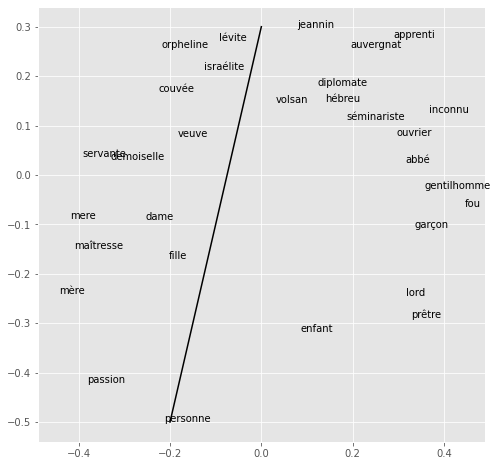

In [ ]:
_, ax = plt.subplots(figsize=(8,8))
ax.scatter(embeddings[:,0], embeddings[:,1], alpha=0)
for i in range(len(vectors)):
    ax.annotate(her_tokens[i], ((embeddings[i,0], embeddings[i,1])))
# draw diagonal line from (-0.2, -0.5) to (0, 0.3)
plt.plot([-0.2, 0], [-0.5, 0.3], 'k-')